In [1]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
____

In [3]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')

train_generator = train_datagen.flow_from_directory(
                                    train_dir,
                                    target_size=(150, 150),
                                    batch_size=20,
                                    class_mode='binary')


Found 2000 images belonging to 2 classes.


In [4]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5),metrics=['acc'])
history = model.fit_generator(train_generator,steps_per_epoch=10,epochs=5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
10/10 [==============================] - 21s 2s/step - loss: 0.6944 - acc: 0.5400
Epoch 2/5
10/10 [==============================] - 14s 1s/step - loss: 0.6946 - acc: 0.5050
Epoch 3/5
10/10 [==============================] - 13s 1s/step - loss: 0.6937 - acc: 0.4900
Epoch 4/5
10/10 [==============================] - 11s 1s/step - loss: 0.6947 - acc: 0.4800
Epoch 5/5
10/10 [==============================] - 11s 1s/step - loss: 0.6931 - acc: 0.5100


In [5]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
img_path = 'cat.1566.jpg'
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

Using TensorFlow backend.


In [6]:
preds = model.predict(x)
print(preds)

[[0.00172897]]


In [7]:
cat_output = model.output[:, 0]
last_conv_layer = model.get_layer('conv2d_3')

In [8]:
from keras import backend as K
grads = K.gradients(cat_output, last_conv_layer.output)[0]
pooled_grads =  K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)

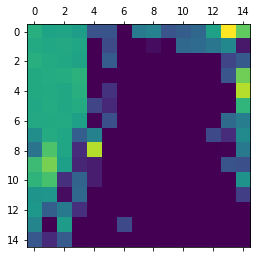

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [12]:
import cv2
img = cv2.imread('cat.1.jpg')
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[1]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('cat_cam.png', superimposed_img)

AttributeError: 'NoneType' object has no attribute 'shape'